# Introduction to Bluebook for Bulldozers Dataset

## Overview of the Dataset

The Bluebook for Bulldozers dataset, sourced from Kaggle, is a comprehensive compilation of historical auction prices for used bulldozers. It includes detailed information about the equipment, such as model type, usage hours, and age, providing an in-depth view of the market dynamics for these heavy machines.

## Importance of the Dataset

This dataset is particularly valuable for understanding price trends and market behavior in the heavy machinery sector. It serves as a rich source for predictive modeling, allowing analysts to forecast future prices and trends in the construction equipment market.

---

# Explainable Machine Learning

## Understanding Explainability in ML

Explainable Machine Learning (ML) refers to techniques and methods that make the output of ML models more understandable to humans. This is crucial in scenarios where decision-making needs to be transparent and justifiable.

## Role of Explainability in Predictive Modeling

In predictive modeling, especially with complex models like those used in the Bluebook dataset, explainability helps in understanding how and why certain predictions are made. This transparency is vital for trust and validation of model predictions in real-world applications.

### Potential Use Case: Analysing Arbitrage Opportunities

#### Defining Arbitrage in Equipment Sales

Arbitrage, in the context of equipment sales, refers to the opportunity to profit from price discrepancies in different markets or time periods. By accurately predicting the future prices of bulldozers, one can identify undervalued machines to purchase and overvalued machines to sell, capitalising on these market inefficiencies.

#### Utilizing ML Predictions for Arbitrage

This subsection explores how the predictions made by the explainable ML model can be used to identify potential arbitrage opportunities in the bulldozer market. The explainable aspect of the model allows for a deeper understanding of the factors influencing price predictions, aiding in more strategic buying and selling decisions.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error, explained_variance_score, mean_squared_log_error
import matplotlib.pyplot as plt
import xplainable as xp
from xplainable.core.ml.regression import XRegressor
from xplainable.core.optimisation.genetic import XEvolutionaryNetwork
from xplainable.core.optimisation.layers import Evolve, Tighten
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
# from xplainable.visualisation.regression import plot_error

In [2]:
print(f"This notebook was created using Xplainable version {xp.__version__}")

This notebook was created using Xplainable version 1.2.3


### Error plot Function Overwrite
**Note**: This will be part of the python package as part of v1.1 patch

In [3]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_error(model, x, y, alpha=0.5, color_column=None):
    fig, ax = plt.subplots(figsize=(12, 8))

    y_pred = model.predict(x)
    mae = mean_absolute_error(y, y_pred)
    errors = abs(y - y_pred)

    if color_column is not None:
        if color_column not in x.columns:
            raise ValueError(f"The color_column {color_column} is not in the DataFrame.")
        
        # Convert column to categorical and get codes and unique values
        categories = x[color_column].astype('category').cat.categories
        codes = x[color_column].astype('category').cat.codes
        unique_codes = np.unique(codes)
        scatter = ax.scatter(y, y_pred, c=codes, alpha=alpha, cmap='plasma')

        # Create a legend with the actual category labels
        handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(code)), 
                               markersize=10) for code in unique_codes]
        ax.legend(handles, categories, title=color_column)

    else:
        scatter = ax.scatter(y, y_pred, c=errors, alpha=alpha, cmap='plasma')
        plt.colorbar(scatter, ax=ax, label='Absolute Error')

    # Line for perfect predictions
    max_val = np.maximum(y.max(), y_pred.max())
    ax.plot([0, max_val], [0, max_val], 'k--', lw=2)

    # Labels and title
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'Scatter Plot of True vs Predicted Values with MAE: {mae:.2f}')

    plt.show()

# Example usage:
# plot_error(model, X_train, y_train, alpha=0.5, color_column='ModelID')

# Building the Dataset

It's possible to download the Bluebook dozer price prediction dataset at the following link: https://www.kaggle.com/c/bluebook-for-bulldozers/data

Following extraction of the .zip file build the dataset as below:

In [4]:
df = pd.read_csv('data/TrainAndValid.csv', parse_dates = ['saledate'])

/var/folders/jf/r9n3ygln3t95z_nyt_3dz8bh0000gn/T/ipykernel_25339/2656427671.py:1: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/TrainAndValid.csv', parse_dates = ['saledate'])


In [5]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Add the machine appendix to concatenate information about the dozer assets

In [6]:
ma = pd.read_csv('data/Machine_Appendix.csv')

In [7]:
ma.head()

,MachineID,ModelID,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,fiProductClassDesc,ProductGroup,ProductGroupDesc,MfgYear,fiManufacturerID,fiManufacturerDesc,PrimarySizeBasis,PrimaryLower,PrimaryUpper
0,113,1355,350L,350,NaN,NaN,L,"Hydraulic Excavator, Track - 50.0 to 66.0 Metr...",TEX,Track Excavators,1994.0,26,Caterpillar,Weight - Metric Tons,50.0,66.0
1,434,3538,416C,416,C,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,BL,Backhoe Loaders,1997.0,26,Caterpillar,Standard Digging Depth - Ft,14.0,15.0
2,534,3538,416C,416,C,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,BL,Backhoe Loaders,1998.0,26,Caterpillar,Standard Digging Depth - Ft,14.0,15.0
3,718,3538,416C,416,C,NaN,NaN,Backhoe Loader - 14.0 to 15.0 Ft Standard Digg...,BL,Backhoe Loaders,2000.0,26,Caterpillar,Standard Digging Depth - Ft,14.0,15.0
4,1753,1580,D5GLGP,D5,G,NaN,LGP,"Track Type Tractor, Dozer - 85.0 to 105.0 Hors...",TTT,Track Type Tractors,2006.0,26,Caterpillar,Horsepower,85.0,105.0


Merging the dataset on the MachineID to extract useful information:
- Find the columns that exist within the machine dictionary that aren't in the training dataset
- Merge the new columns on the existing train dataset to enrich the information

In [8]:
new_cols = [col for col in ma.columns if col not in df.columns]
ma[new_cols].head()

,MfgYear,fiManufacturerID,fiManufacturerDesc,PrimarySizeBasis,PrimaryLower,PrimaryUpper
0,1994.0,26,Caterpillar,Weight - Metric Tons,50.0,66.0
1,1997.0,26,Caterpillar,Standard Digging Depth - Ft,14.0,15.0
2,1998.0,26,Caterpillar,Standard Digging Depth - Ft,14.0,15.0
3,2000.0,26,Caterpillar,Standard Digging Depth - Ft,14.0,15.0
4,2006.0,26,Caterpillar,Horsepower,85.0,105.0


In [9]:
merge_col = "MachineID"
df = pd.merge(df, ma[[merge_col]+ new_cols ],on='MachineID', how='left')

# Feature Engineering Overview

**Note**: The approach to feature engineering presented here is foundational and does not encompass the full depth typically seen in data science projects. The release of version 1.1 has improved our system's ability to handle missing values directly, which reduces the time needed to process and analyse data that contains null entries.

In [10]:
# Extract Purchase date information
df['saleyear'] = df['saledate'].dt.year
df['salemonth'] = df['saledate'].dt.month
df['saledayofweek'] = df['saledate'].dt.day_name()

# Drop the Sale Date following extraction of features
df.drop('saledate', inplace=True, axis=1)

In [11]:
#Rename columns
df.columns = [col.replace("_","") for col in df.columns]

In [12]:
#Filter our erroneous purchase values
df = df[df.YearMade > 1920]

In [13]:
#Turn model id into a categorical value so it doesn't create regression splits
df["ModelID"] = df["ModelID"].astype(str) 

In [14]:
df

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,SteeringControls,MfgYear,fiManufacturerID,fiManufacturerDesc,PrimarySizeBasis,PrimaryLower,PrimaryUpper,saleyear,salemonth,saledayofweek
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,521D,...,Conventional,2004.0,25,Case,Horsepower,110.0,120.0,2006,11,Thursday
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,950FII,...,Conventional,1996.0,26,Caterpillar,Horsepower,150.0,175.0,2004,3,Friday
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,226,...,NaN,2001.0,26,Caterpillar,Operating Capacity - Lbs,1351.0,1601.0,2004,2,Thursday
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,NaN,2010.0,103,Komatsu,Horsepower,225.0,250.0,2011,5,Thursday
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,NaN,2007.0,121,Bobcat,Operating Capacity - Lbs,1601.0,1751.0,2009,7,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6333344,10000.0,1919201,21435,149,2.0,2005,NaN,NaN,30NX,...,NaN,2005.0,2552,IHI,Weight - Metric Tons,2.0,3.0,2012,3,Wednesday
412694,6333345,10500.0,1882122,21436,149,2.0,2005,NaN,NaN,30NX2,...,NaN,2005.0,2552,IHI,Weight - Metric Tons,3.0,4.0,2012,1,Saturday
412695,6333347,12500.0,1944213,21435,149,2.0,2005,NaN,NaN,30NX,...,NaN,2005.0,2552,IHI,Weight - Metric Tons,2.0,3.0,2012,1,Saturday
412696,6333348,10000.0,1794518,21435,149,2.0,2006,NaN,NaN,30NX,...,NaN,2006.0,2552,IHI,Weight - Metric Tons,2.0,3.0,2012,3,Wednesday


### Train on the top 6 dozers assets by count
For timeliness of training filter the data on the Top 6 assets by count

In [15]:
models_to_train = df.ModelID.value_counts().index[:10].to_list()

In [16]:
models_to_train

['4605',
 '3538',
 '4604',
 '3170',
 '3362',
 '3537',
 '4603',
 '3171',
 '3357',
 '3178']

In [17]:
df[df.ModelID.isin(models_to_train)]

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,SteeringControls,MfgYear,fiManufacturerID,fiManufacturerDesc,PrimarySizeBasis,PrimaryLower,PrimaryUpper,saleyear,salemonth,saledayofweek
5,1139255,26500.0,1001274,4605,121,3.0,2004,508.0,Low,310G,...,NaN,2004.0,43,John Deere,Standard Digging Depth - Ft,14.0,15.0,2008,12,Thursday
10,1139278,24000.0,1024998,4605,121,3.0,2004,1414.0,Medium,310G,...,NaN,2004.0,43,John Deere,Standard Digging Depth - Ft,14.0,15.0,2008,8,Thursday
15,1139291,19000.0,1004810,4604,121,3.0,1999,2450.0,Medium,310E,...,NaN,1999.0,43,John Deere,Standard Digging Depth - Ft,14.0,15.0,2006,11,Thursday
62,1139469,23000.0,1058869,3171,121,3.0,1998,9987.0,High,580L,...,NaN,1998.0,25,Case,Standard Digging Depth - Ft,14.0,15.0,2007,5,Thursday
82,1139515,33000.0,1015565,4605,121,3.0,2002,1268.0,Medium,310G,...,NaN,2002.0,43,John Deere,Standard Digging Depth - Ft,14.0,15.0,2004,7,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410243,6288239,18200.0,1835461,4604,149,99.0,2000,48.0,Low,310E,...,NaN,2000.0,43,John Deere,Standard Digging Depth - Ft,14.0,15.0,2012,2,Wednesday
410244,6288240,25250.0,1903914,4605,149,0.0,2005,1988.0,Low,310G,...,NaN,2005.0,43,John Deere,Standard Digging Depth - Ft,14.0,15.0,2012,1,Saturday
410245,6288241,25250.0,1860549,4605,149,99.0,2006,NaN,NaN,310G,...,NaN,2006.0,43,John Deere,Standard Digging Depth - Ft,14.0,15.0,2012,4,Wednesday
410246,6288243,25000.0,1846184,4605,149,1.0,2006,NaN,NaN,310G,...,NaN,2006.0,43,John Deere,Standard Digging Depth - Ft,14.0,15.0,2012,3,Thursday


In [18]:
data = df[df.ModelID.isin(models_to_train)]
m = data.isna().sum()
data = data[[col for col in data.columns if col not in data.columns[m == len(data)]]]

#Drop cols cardinality of 1
s = data.nunique()
car_cols = data.columns[(s == 1)]
data = data.drop(columns=car_cols)

#Update numeric columns to be float64
n_cols = data.select_dtypes(include=np.number).columns.tolist()
data[n_cols] = data[n_cols].astype('float64')

In [19]:
data.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,TireSize,MfgYear,fiManufacturerID,fiManufacturerDesc,PrimarySizeBasis,PrimaryLower,PrimaryUpper,saleyear,salemonth,saledayofweek
5,1139255.0,26500.0,1001274.0,4605,121.0,3.0,2004.0,508.0,Low,310G,...,NaN,2004.0,43.0,John Deere,Standard Digging Depth - Ft,14.0,15.0,2008.0,12.0,Thursday
10,1139278.0,24000.0,1024998.0,4605,121.0,3.0,2004.0,1414.0,Medium,310G,...,NaN,2004.0,43.0,John Deere,Standard Digging Depth - Ft,14.0,15.0,2008.0,8.0,Thursday
15,1139291.0,19000.0,1004810.0,4604,121.0,3.0,1999.0,2450.0,Medium,310E,...,NaN,1999.0,43.0,John Deere,Standard Digging Depth - Ft,14.0,15.0,2006.0,11.0,Thursday
62,1139469.0,23000.0,1058869.0,3171,121.0,3.0,1998.0,9987.0,High,580L,...,NaN,1998.0,25.0,Case,Standard Digging Depth - Ft,14.0,15.0,2007.0,5.0,Thursday
82,1139515.0,33000.0,1015565.0,4605,121.0,3.0,2002.0,1268.0,Medium,310G,...,NaN,2002.0,43.0,John Deere,Standard Digging Depth - Ft,14.0,15.0,2004.0,7.0,Thursday


### Addressing Multicollinearity in Model Interpretability

It's well-understood in data science that multicollinearity can significantly hamper the interpretability of models, particularly those based on linear assumptions. The code snippet above demonstrates a rudimentary approach to mitigating multicollinearity by removing highly correlated features. However, it's important to acknowledge that this is a simplified illustration; in practice, the interplay between features can be more subtle and complex.

For robust feature selection and to enhance model explainability, we employ automated feature selection techniques that are thoroughly documented in our project's documentation. These methods go beyond pairwise correlations, considering the multidimensional structure of the data to retain the most informative features. While the current example is not exhaustive, it serves to highlight a fundamental step in preprocessing for linear models. Practitioners are encouraged to leverage our automatic feature selection capabilities to refine their models further and to ensure that the explanatory variables employed are truly reflective of independent factors influencing the response variable.


In [20]:
data["AgeAtSale"] = df["saleyear"] - df["MfgYear"]

In [21]:
drop_cols = [
    # "saleyear", #--> Data encoded in Age at Sale
    "MfgYear", #--> Data encoded in Age at Sale
    "YearMade", #--> Multicollinearity with MfgYear
            ]

In [22]:
target = 'SalePrice'
id_columns=["SalesID",'MachineID','auctioneerID','datasource']

### Split the train and validation set

In [23]:
data_train = data[data.saleyear!=2012]
data_val = data[data.saleyear==2012]
data_train= data_train.drop(columns=drop_cols)
data_val=data_val.drop(columns=drop_cols)

#Create the training and validation set
X_train, y_train = data_train.drop('SalePrice', axis=1), data_train['SalePrice']
X_valid, y_valid = data_val.drop('SalePrice', axis=1), data_val['SalePrice']

In [24]:
model = XRegressor(ignore_nan=False)

### Initial fit of the Regressor

In [25]:
model.fit(X_train, y_train,id_columns=id_columns)

In [26]:
model.evaluate(X_train, y_train)

{'Explained Variance': 0.8476,
 'MAE': 4292.3689,
 'MAPE': 0.1616,
 'MSE': 39079631.4865,
 'RMSE': 6251.3704,
 'RMSLE': nan,
 'R2 Score': 0.8476}

In [27]:
model.explain()

alt.HConcatChart(...)

### Optimising the Model

In [28]:
network = XEvolutionaryNetwork(model)

# Add the layers
# Start with an initial Tighten layer
network.add_layer(
    Tighten(
        iterations=100,
        learning_rate=0.1,
        early_stopping=20
        )
    )

# Add an Evolve layer with a high severity
network.add_layer(
    Evolve(
        mutations=100,
        generations=50,
        max_severity=0.5,
        max_leaves=20,
        early_stopping=20
        )
    )

# Add another Evolve layer with a lower severity and reach
network.add_layer(
    Evolve(
        mutations=100,
        generations=50,
        max_severity=0.3,
        max_leaves=15,
        early_stopping=20
        )
    )

# Add a final Tighten layer with a low learning rate
network.add_layer(
    Tighten(
        iterations=100,
        learning_rate=0.025,
        early_stopping=20
        )
    )

# Fit the network (before or after adding layers)
network.fit(X_train.drop(columns=id_columns), y_train)

# Run the network
network.optimise()

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
model.evaluate(X_train, y_train)

{'Explained Variance': 0.8446,
 'MAE': 4134.8991,
 'MAPE': 0.1486,
 'MSE': 40127897.0119,
 'RMSE': 6334.6584,
 'RMSLE': nan,
 'R2 Score': 0.8435}

Simply by fitting a combination of 6 Tighten and Evolution layers we have decreased the MAE by approximately **9000**. Play around with more layers to see if it's possible to obtain better results.

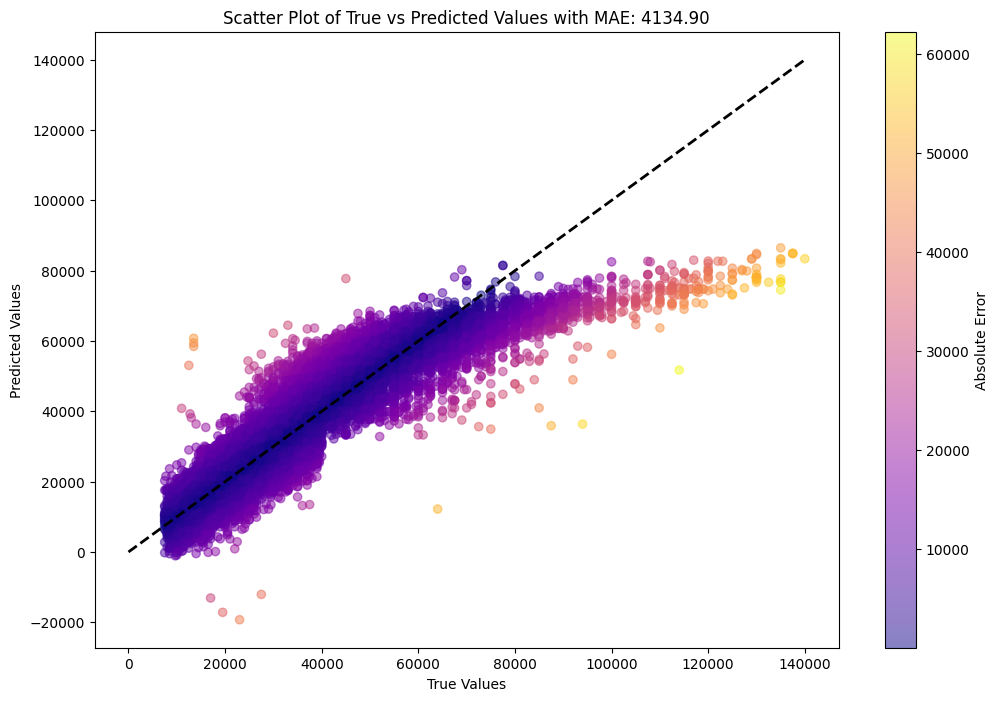

In [30]:
plot_error(model, X_train, y_train)

Comparing against the validation set

In [31]:
model.evaluate(X_valid, y_valid)

{'Explained Variance': 0.8436,
 'MAE': 4861.969,
 'MAPE': 0.1796,
 'MSE': 46412730.8316,
 'RMSE': 6812.689,
 'RMSLE': nan,
 'R2 Score': 0.8047}

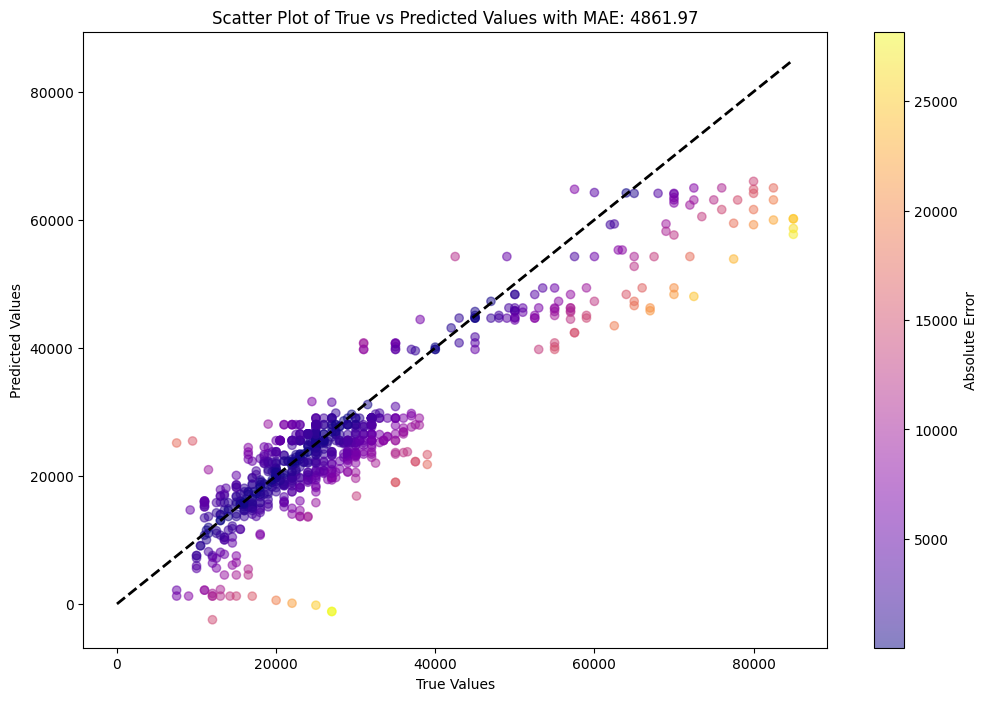

In [32]:
plot_error(model, X_valid, y_valid)

In [33]:
model.explain()

alt.HConcatChart(...)

### Explaining the variance in the Error Plot

Prior to examining the detailed error plot, it is essential to consider the real-world operational differences among various bulldozer models, as well as the insights provided by subject matter experts (SMEs). These differences are likely to manifest as distinct groupings in the predicted versus actual results. Each model type's unique characteristics—such as age, usage and maintenance history factors that could create these groups, affecting the sale prices and thus the prediction accuracy. Recognizing these potential variances will prepare us to understand and address the disparities in the predictive performance across different Model IDs that the following plot will reveal.


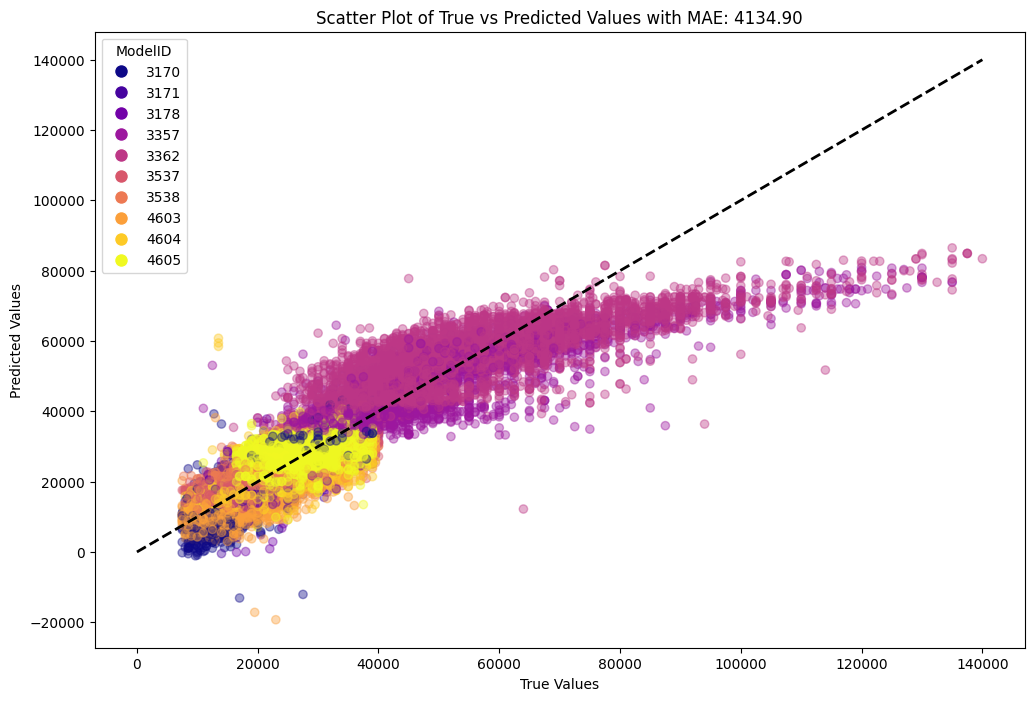

In [34]:
plot_error(model, X_train, y_train, alpha=0.4, color_column="ModelID")

### Insights from Scatter Plot Analysis

The scatter plot displayed above demonstrates a significant variation in the predictive accuracy across different Model IDs, as indicated by the spread of points in relation to the black dashed line, which represents perfect prediction. Models such as those in the yellow cluster are closely aligned with the line, suggesting higher prediction accuracy for these Model IDs. This observation underscores the importance of partitioning the dataset to develop model-specific predictive algorithms. By doing so, we can account for the unique characteristics of each model, which may include factors specific to the model that affect the score contributions.


## Creating a Partitioned Model

In [37]:
from xplainable.core.models import PartitionedRegressor
import pandas as pd
from sklearn.model_selection import train_test_split

# Train your model (this will open an embedded gui)
partitioned_model = PartitionedRegressor(partition_on='ModelID')

# Iterate over the unique values in the partition column
for partition in df.ModelID.value_counts().index[:10].to_list():
    # Get the data for the partition
    part = data[data['ModelID'] == partition].drop(columns=drop_cols)
    x_train_partition, y_train_partition = part.drop('SalePrice', axis=1), part['SalePrice']
    
    # Fit the embedded model
    model_partition = XRegressor()
    model_partition.fit(x_train_partition, y_train_partition, id_columns=id_columns)
    
    #Unhide this if you want to optimise the results
    # network = XEvolutionaryNetwork(model_partition)
    
    # # Add the layers
    # # Start with an initial Tighten layer
    # network.add_layer(
    #     Tighten(
    #         iterations=100,
    #         learning_rate=0.1,
    #         early_stopping=20
    #         )
    #     )
    
    # # Add an Evolve layer with a high severity
    # network.add_layer(
    #     Evolve(
    #         mutations=100,
    #         generations=50,
    #         max_severity=0.5,
    #         max_leaves=20,
    #         early_stopping=20
    #         )
    #     )
    
    # # Add another Evolve layer with a lower severity and reach
    # network.add_layer(
    #     Evolve(
    #         mutations=100,
    #         generations=50,
    #         max_severity=0.3,
    #         max_leaves=15,
    #         early_stopping=20
    #         )
    #     )
    
    # # Add a final Tighten layer with a low learning rate
    # network.add_layer(
    #     Tighten(
    #         iterations=100,
    #         learning_rate=0.025,
    #         early_stopping=20
    #         )
    #     )
    
    # # Fit the network (before or after adding layers)
    # network.fit(X_train.drop(columns=id_columns), y_train)

    # # Run the network
    # network.optimise()

    # Add the model to the partitioned model
    partitioned_model.add_partition(model_partition, partition)

# Predict on the partitioned model
y_pred = partitioned_model.predict(X_valid)

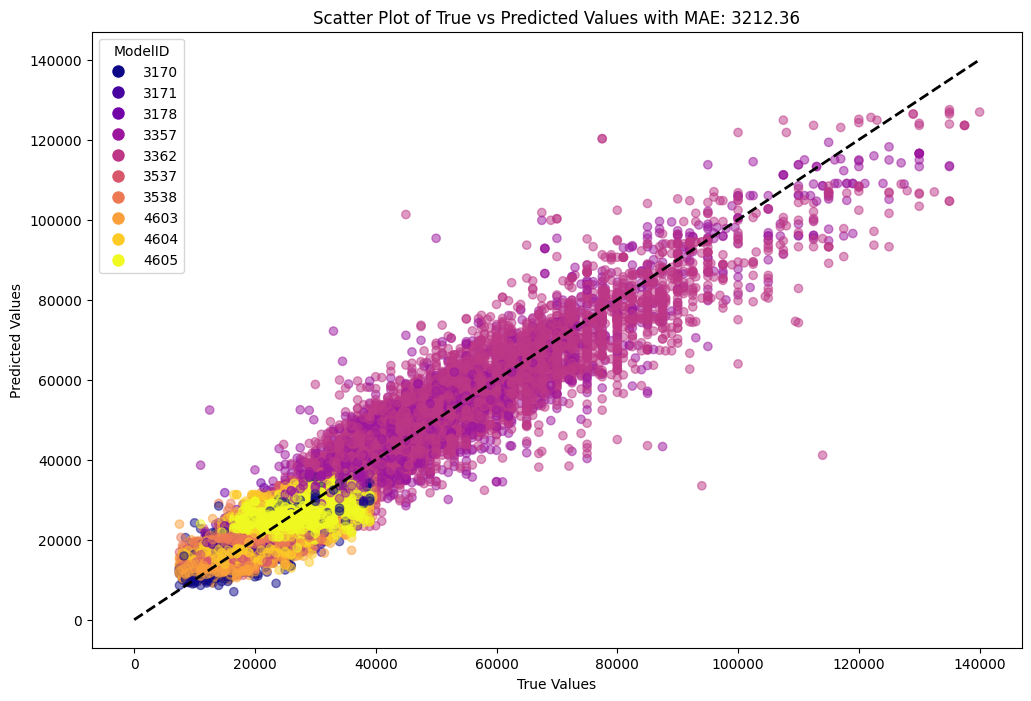

In [38]:
plot_error(partitioned_model, X_train, y_train, color_column="ModelID")

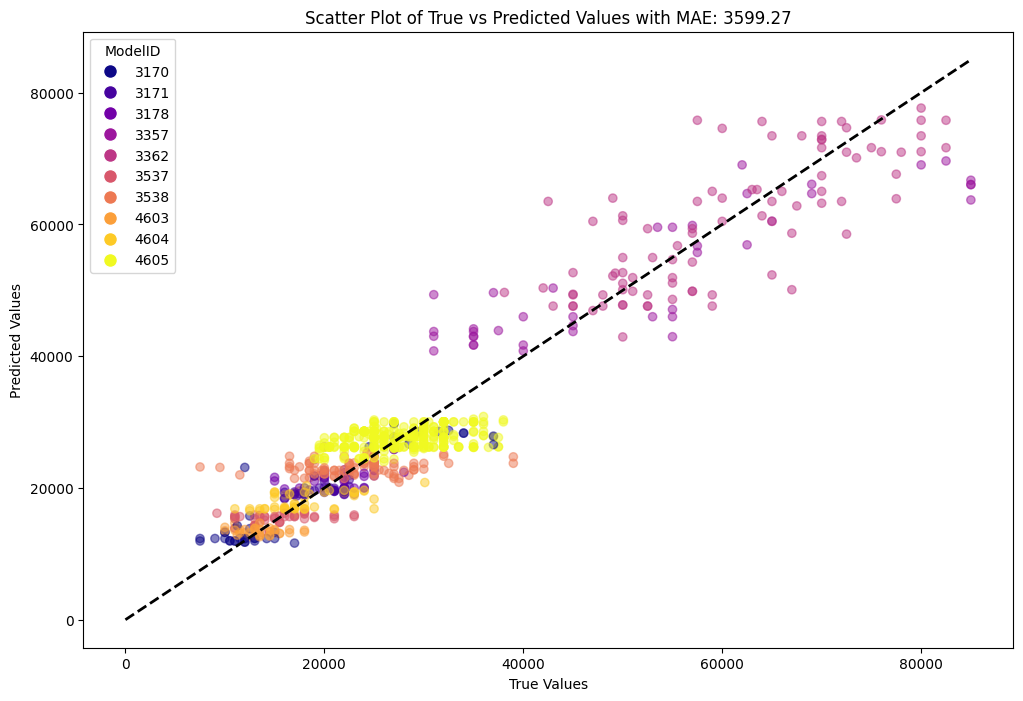

In [39]:
plot_error(partitioned_model, X_valid, y_valid, color_column="ModelID")

### Evaluation of Model Predictions Against Validation Data

The scatter plot illustrates our model's performance on the validation set, comparing the true values against the predicted values for various bulldozer models. While the trend line shows that our model predictions are generally aligned with the true values, there is an observable underprediction across the data points, as evidenced by the mean absolute error (MAE) of 3599 vs 3212 on the train.

#### Considerations for Model Refinement:

- The impact of the mining boom in Australia in 2012, referenced from the Reserve Bank of Australia's report, suggests an economic context that may influence equipment prices. Incorporating macroeconomic indicators could potentially enhance the model's predictive accuracy.

- Introducing time series features that capture year-over-year changes could offer a more nuanced understanding of price fluctuations over time, rather than relying solely on 'Age at Sale', which may not fully encapsulate such trends.

These considerations point towards the inclusion of external economic factors and more sophisticated time-based features to improve the model's prediction capabilities. Further analysis and iterative model tuning will be required to reduce the prediction error and align the model outputs more closely with the validation data.


#### Further Investigation:

- An analysis of the trend line derived from time series splits (Age at Sale) could reveal insights into future forecasting capabilities. By extending this trend line, we can project forward forecasts that anticipate equipment prices. This approach could be particularly beneficial for capturing the trajectory of market shifts influenced by macroeconomic trends, such as the mining boom.

Should anyone be interested in contributing to the development of this predictive feature or investigating this further, please feel free to add to the issues on our repository or contact us directly at contact@xplainable.io.

### Access model partitions and plot explanations

In [40]:
partitioned_model.partitions

{'4605': <xplainable.core.ml.regression.XRegressor at 0x2d463a1a0>,
 '3538': <xplainable.core.ml.regression.XRegressor at 0x2d45e0160>,
 '4604': <xplainable.core.ml.regression.XRegressor at 0x2d45e1c60>,
 '3170': <xplainable.core.ml.regression.XRegressor at 0x2d45e3af0>,
 '3362': <xplainable.core.ml.regression.XRegressor at 0x2d45e0400>,
 '3537': <xplainable.core.ml.regression.XRegressor at 0x1719da0e0>,
 '4603': <xplainable.core.ml.regression.XRegressor at 0x2d4532290>,
 '3171': <xplainable.core.ml.regression.XRegressor at 0x2d45328f0>,
 '3357': <xplainable.core.ml.regression.XRegressor at 0x171ad8190>,
 '3178': <xplainable.core.ml.regression.XRegressor at 0x1719ca200>}

In [41]:
partitioned_model.partitions['3538'].explain()

alt.HConcatChart(...)